# Sierraleone Solar Dataset EDA
## Profile, clean, and explore Sierraleone solar data for insights.

In [1]:
# Importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
import plotly.graph_objects as go
%matplotlib inline

In [2]:
# Loading Data
df = pd.read_csv('../data/sierraleone-bumbuna.csv')
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

Shape: (525600, 19)
Columns: ['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation', 'TModA', 'TModB', 'Comments']


## Summary Statistics & Missing Values
Stats for numeric columns, flag columns with >5% nulls.

In [3]:
# Numeric columns
numeric_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Precipitation', 'TModA', 'TModB']
print("Summary Stats:")
print(df[numeric_cols].describe().round(2))

# Missing values
print("\nMissing Values:")
missing = df.isna().sum()
missing_pct = (missing / len(df) * 100).round(2)
print(pd.DataFrame({'Count': missing, 'Percent': missing_pct}))
print("\nColumns with >5% Nulls:", missing_pct[missing_pct > 5].index.tolist())

Summary Stats:
             GHI        DNI        DHI       ModA       ModB       Tamb  \
count  525600.00  525600.00  525600.00  525600.00  525600.00  525600.00   
mean      201.96     116.38     113.72     206.64     198.11      26.32   
std       298.50     218.65     158.95     300.90     288.89       4.40   
min       -19.50      -7.80     -17.90       0.00       0.00      12.30   
25%        -2.80      -0.30      -3.80       0.00       0.00      23.10   
50%         0.30      -0.10      -0.10       3.60       3.40      25.30   
75%       362.40     107.00     224.70     359.50     345.40      29.40   
max      1499.00     946.00     892.00    1507.00    1473.00      39.90   

              RH         WS     WSgust    WSstdev         WD    WDstdev  \
count  525600.00  525600.00  525600.00  525600.00  525600.00  525600.00   
mean       79.45       1.15       1.69       0.36     133.04       7.17   
std        20.52       1.24       1.62       0.30     114.28       7.54   
min      

## Outlier Detection & Cleaning
Z-scores for GHI, DNI, DHI, ModA, ModB, WS, WSgust; handle negatives, missing values.

In [4]:
# Key columns for cleaning
key_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Check for negative values
print("Negative Values in Key Columns:")
negatives = {col: (df[col] < 0).sum() for col in key_cols}
for col, count in negatives.items():
    print(f"{col}: {count}")

# Compute Z-scores for outliers
z_scores = stats.zscore(df[key_cols].fillna(df[key_cols].median()))
outliers = (abs(z_scores) > 3).any(axis=1)
print(f"\nOutliers (|Z|>3): {outliers.sum()} rows")

# Clean: Remove negatives in GHI, DNI, DHI; impute missing values with median
df_clean = df.copy()
for col in ['GHI', 'DNI', 'DHI']:  # Remove negatives in solar irradiance columns
    df_clean = df_clean[df_clean[col] >= 0]
df_clean[key_cols] = df_clean[key_cols].fillna(df[key_cols].median())

# Verify cleaned data
print(f"Cleaned Shape: {df_clean.shape}")
print("Remaining Negatives in Key Columns:")
for col in key_cols:
    print(f"{col}: {(df_clean[col] < 0).sum()}")

# Export cleaned DataFrame
df_clean.to_csv('../data/sierraleone_clean.csv', index=False)
print("Cleaned data exported to '../data/sierraleone_clean.csv'")

Negative Values in Key Columns:
GHI: 261135
DNI: 266352
DHI: 263128
ModA: 0
ModB: 0
WS: 0
WSgust: 0

Outliers (|Z|>3): 16292 rows
Cleaned Shape: (238872, 19)
Remaining Negatives in Key Columns:
GHI: 0
DNI: 0
DHI: 0
ModA: 0
ModB: 0
WS: 0
WSgust: 0
Cleaned data exported to '../data/sierraleone_clean.csv'


## Time Series Analysis
Plot GHI, DNI, DHI, Tamb vs. Timestamp; analyze patterns.

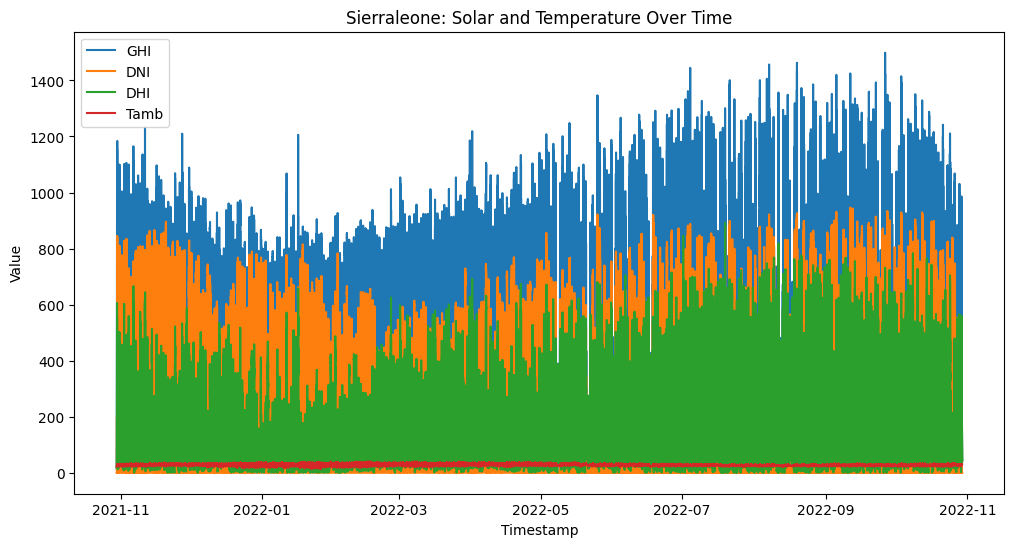

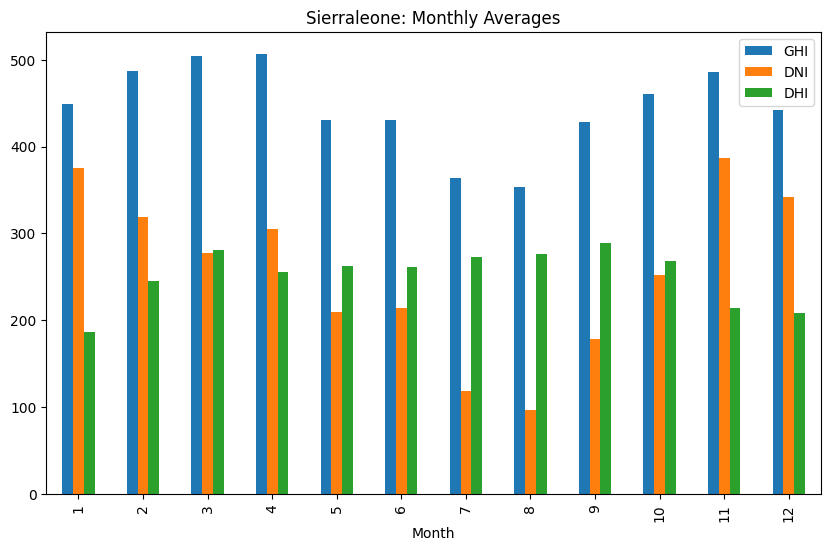

In [5]:
df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'])
plt.figure(figsize=(12, 6))
for col in ['GHI', 'DNI', 'DHI', 'Tamb']:
    plt.plot(df_clean['Timestamp'], df_clean[col], label=col)
plt.title('Sierraleone: Solar and Temperature Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

# Monthly averages
df_clean['Month'] = df_clean['Timestamp'].dt.month
monthly = df_clean.groupby('Month')[['GHI', 'DNI', 'DHI']].mean()
monthly.plot(kind='bar', figsize=(10, 6), title='Sierraleone: Monthly Averages')
plt.show()

## Cleaning Impact
Average ModA, ModB by Cleaning flag.

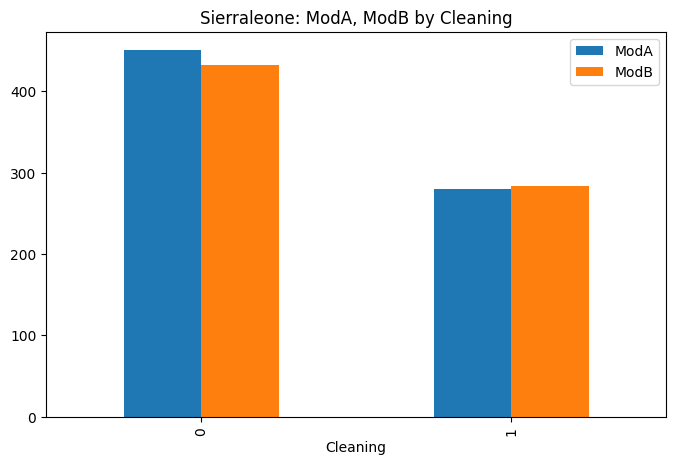

In [6]:
cleaning_impact = df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean()
cleaning_impact.plot(kind='bar', figsize=(8, 5), title='Sierraleone: ModA, ModB by Cleaning')
plt.show()

## Correlation Analysis
Heatmap for GHI, DNI, DHI, TModA, TModB.

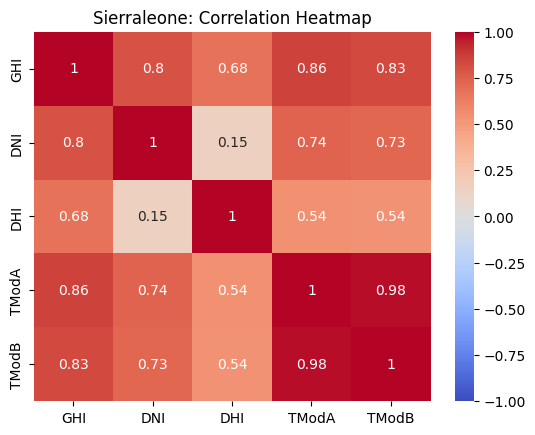

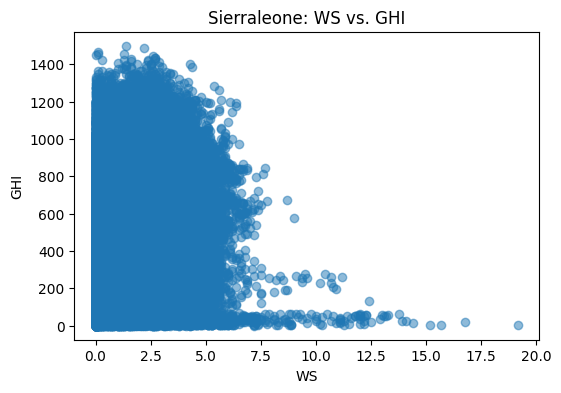

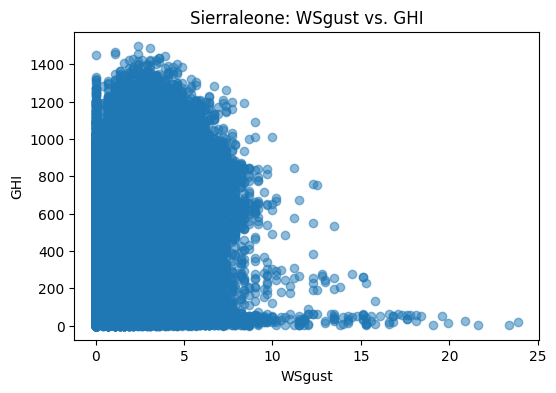

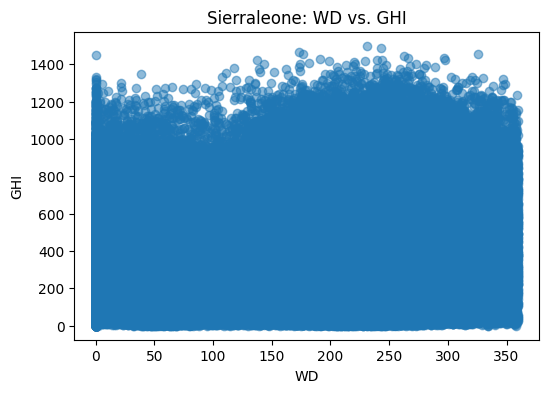

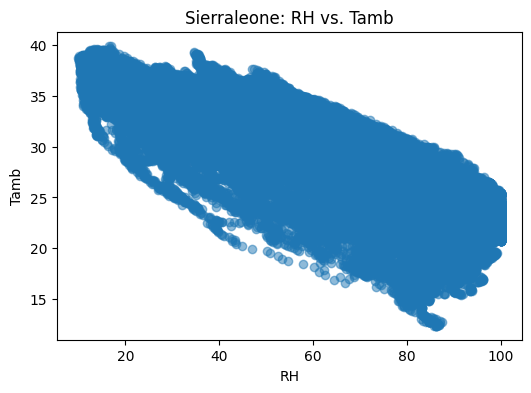

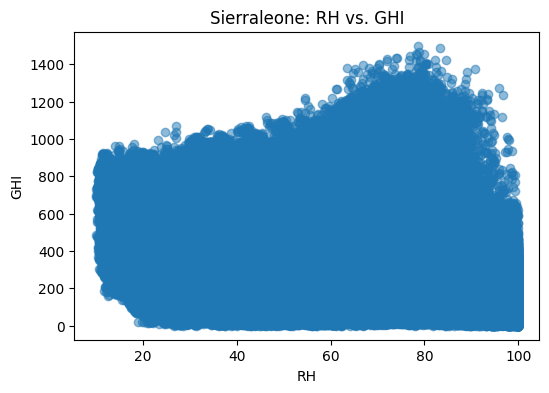

In [7]:
corr_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
sns.heatmap(df_clean[corr_cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Sierraleone: Correlation Heatmap')
plt.show()

# Scatter plots
for col in ['WS', 'WSgust', 'WD']:
    plt.figure(figsize=(6, 4))
    plt.scatter(df_clean[col], df_clean['GHI'], alpha=0.5)
    plt.title(f'Sierraleone: {col} vs. GHI')
    plt.xlabel(col)
    plt.ylabel('GHI')
    plt.show()

for col in ['Tamb','GHI']:    
    plt.figure(figsize=(6, 4))
    plt.scatter(df_clean['RH'], df_clean[col], alpha=0.5)
    plt.title(f'Sierraleone: RH vs. {col}')
    plt.xlabel('RH')
    plt.ylabel(col)
    plt.show()


## Wind & Distribution Analysis
Wind rose for WS/WD, histograms for GHI, WS.

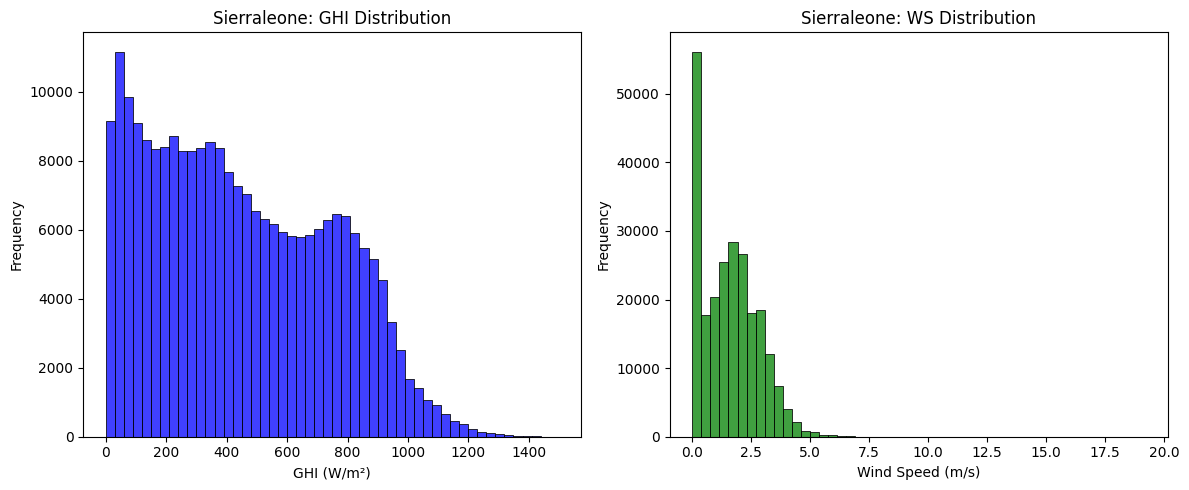

In [8]:
# Wind rose using Plotly Barpolar
bins = np.linspace(0, 360, 17)  # 16 bins for 360 degrees
wd_binned = pd.cut(df_clean['WD'], bins, include_lowest=True, labels=bins[:-1])
ws_mean = df_clean.groupby(wd_binned, observed=True)['WS'].mean().reset_index()
ws_mean['WD'] = ws_mean['WD'].astype(float)  # Ensure WD is numeric

# Create wind rose with labels for r and theta on hover
fig = go.Figure(data=[
    go.Barpolar(
        r=ws_mean['WS'],
        theta=ws_mean['WD'],
        marker_colorscale='Viridis',
        marker_color=ws_mean['WS'],
        name='Wind Speed (m/s)',
        text=[f'r={r:.1f}, θ={θ:.0f}°' for r, θ in zip(ws_mean['WS'], ws_mean['WD'])],  # Labels for r and theta
        hoverinfo='text',  # Show labels on hover
        hoverlabel=dict(
            font=dict(size=12, color='black')  # Style hover labels
        )
    )
])
fig.update_layout(
    title='Sierraleone: Wind Rose (Average WS by WD)',
    polar=dict(
        radialaxis=dict(
            visible=True,
            title='Wind Speed (m/s)'
        ),
        angularaxis=dict(
            direction='clockwise',
            showticklabels=True
        )
    ),
    annotations=[
        dict(
            text='Wind Direction (degrees)',
            x=0.5,
            y=-0.1,
            xref='paper',
            yref='paper',
            showarrow=False,
            font=dict(size=12)
        )
    ],
    showlegend=True,
    width=800,  # Increase circle size
    height=800  # Increase circle size
)
fig.show()

# Histograms for GHI and WS (unchanged)
plt.figure(figsize=(12, 5))

# GHI histogram
plt.subplot(1, 2, 1)
sns.histplot(df_clean['GHI'], bins=50, color='blue')
plt.title('Sierraleone: GHI Distribution')
plt.xlabel('GHI (W/m²)')
plt.ylabel('Frequency')

# WS histogram
plt.subplot(1, 2, 2)
sns.histplot(df_clean['WS'], bins=50, color='green')
plt.title('Sierraleone: WS Distribution')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Temperature Analysis
RH influence on Tamb, GHI.

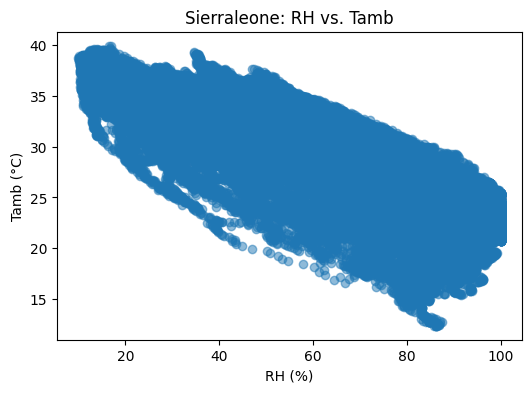

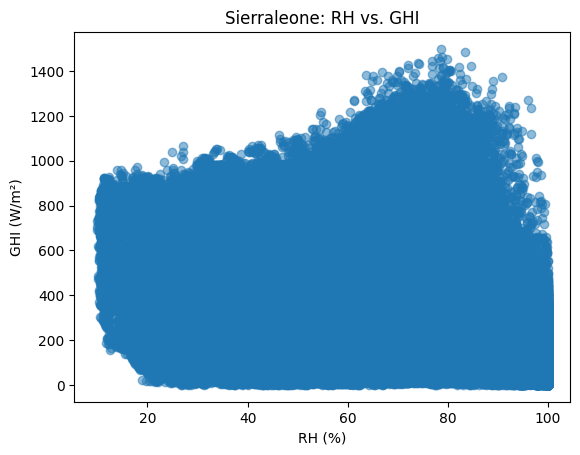

In [9]:
plt.figure(figsize=(6, 4))
plt.scatter(df_clean['RH'], df_clean['Tamb'], alpha=0.5)
plt.title('Sierraleone: RH vs. Tamb')
plt.xlabel('RH (%)')
plt.ylabel('Tamb (°C)')
plt.show()

plt.scatter(df_clean['RH'], df_clean['GHI'], alpha=0.5)
plt.title('Sierraleone: RH vs. GHI')
plt.xlabel('RH (%)')
plt.ylabel('GHI (W/m²)')
plt.show()


## Bubble Chart
GHI vs. Tamb, bubble size = RH.

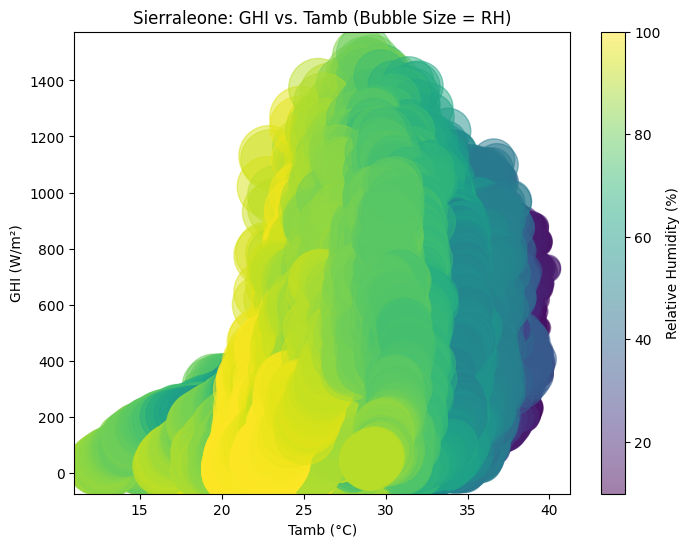

In [10]:
# Bubble chart: GHI vs. Tamb, bubble size = RH
plt.figure(figsize=(8, 6))
plt.scatter(
    df_clean['Tamb'],
    df_clean['GHI'],
    s=df_clean['RH'] * 20,  # Scale RH for bubble size
    alpha=0.5,
    c=df_clean['RH'],  # Color by RH for clarity
    cmap='viridis'
)
plt.colorbar(label='Relative Humidity (%)')
plt.title('Sierraleone: GHI vs. Tamb (Bubble Size = RH)')
plt.xlabel('Tamb (°C)')
plt.ylabel('GHI (W/m²)')
plt.show()